# Méthode de boosting (regression)

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from math import log,sqrt,exp

import random
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from itertools import cycle
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import GradientBoostingRegressor



# Chargement et mise en forme des données

In [25]:
PATH = '../requetes/'
data = pd.read_csv(PATH+'requetes_total.csv')
data.head()

,avatar_id,city,date,language,mobile,hotel_id,price,stock,group,brand,parking,pool,children_policy
0,29822,madrid,2,bulgarian,0,127,69,0,Independant,Independant,1,0,0
1,29822,madrid,2,bulgarian,0,941,67,0,Independant,Independant,1,0,0
2,29822,madrid,2,bulgarian,0,186,129,0,Yin Yang,Ardisson,1,0,0
3,29822,madrid,2,bulgarian,0,633,148,2,Morriott International,CourtYord,0,0,0
4,29822,madrid,2,bulgarian,0,241,126,0,Boss Western,J.Halliday Inn,1,0,0


In [26]:
# transformation des données en fonction de celles qu'on a identifié dans le notebook d'analyse des données de requetes
data["price_mod"]=data["price"].map(lambda x: log(x))
data["stock_mod"]=data["stock"].map(lambda x: sqrt(x))
data_mod = data.drop(["price","stock"],axis=1)

In [4]:
# ajout de la colonne order request
order = np.zeros(len(data_mod.index),dtype=int)

# référence pour le début = la première ligne du dataframe
ref_line = 0
order[0] = 1

for line in range(0,len(data_mod.index)):
    request_line = data_mod.loc[line,['avatar_id','city','date']].to_numpy()
    request_ref_line = data_mod.loc[ref_line,['avatar_id','city','date']].to_numpy() 
    if (request_line == request_ref_line).all() :
        order[line] = order[ref_line]
    else : 
        order[line] = order[ref_line]+1
        ref_line = line

In [27]:
data_mod['order_requests'] = order
data_mod.head()

,avatar_id,city,date,language,mobile,hotel_id,group,brand,parking,pool,children_policy,price_mod,stock_mod,order_requests
0,29822,madrid,2,bulgarian,0,127,Independant,Independant,1,0,0,4.234107,0.000000,1
1,29822,madrid,2,bulgarian,0,941,Independant,Independant,1,0,0,4.204693,0.000000,1
2,29822,madrid,2,bulgarian,0,186,Yin Yang,Ardisson,1,0,0,4.859812,0.000000,1
3,29822,madrid,2,bulgarian,0,633,Morriott International,CourtYord,0,0,0,4.997212,1.414214,1
4,29822,madrid,2,bulgarian,0,241,Boss Western,J.Halliday Inn,1,0,0,4.836282,0.000000,1


In [28]:
# définition des variables quntitatives et qualitatives : 
var_quant = ["date","stock_mod"]
var_quali = ["city","language", "mobile","group","brand","parking","pool","children_policy"]

for var in var_quali :
    data_mod[var]=pd.Categorical(data_mod[var],ordered=False)

data_mod.dtypes

avatar_id             int64
city               category
date                  int64
language           category
mobile             category
hotel_id              int64
group              category
brand              category
parking            category
pool               category
children_policy    category
price_mod           float64
stock_mod           float64
order_requests        int64
dtype: object

In [29]:
# Renormalisation des variables quantitatives : 
scalerX = StandardScaler()  
scalerX.fit(data_mod[var_quant])  
X_quant = pd.DataFrame(scalerX.transform(data_mod[var_quant]),columns=var_quant)

# Séparation de l'output :
Y = data_mod["price_mod"].to_numpy()

In [30]:
# transformation des variables qualitatives en dummy variables
X_dum = pd.get_dummies(data_mod[var_quali])
X = pd.concat([data_mod[['order_requests','avatar_id','hotel_id']],X_quant,X_dum],axis=1)

# Fonctions utiles

In [31]:
def plot_pred_obs(Y_true,Y_pred): 
    plt.figure(figsize=(5,5))
    plt.plot(Y_true,Y_pred,"o",markersize = 0.4)
    plt.xlabel("prix prédit")
    plt.ylabel("prix observé")
    plt.show()

def scatterplot_residuals(Y_true,Y_pred):
    plt.figure(figsize=(5,5))
    plt.plot(Y_pred,Y_true-Y_pred,"o",markersize = 0.4)
    plt.xlabel(u"valeurs prédites")
    plt.ylabel(u"Résidus")
    plt.title("Residus pénalité L1 Lasso") 
    plt.hlines(0,0,3)
    plt.show()
    
def histogram_residuals(Y_true,Y_pred):
    plt.figure(figsize=(10,5))
    plt.hist(Y_true-Y_pred,bins=20)
    plt.title('histogramme des résidus')
    plt.xlabel('valeur des résidus')
    plt.ylabel('nombre de prédictions')
    plt.show()

def download_pred_Xtest(Y_pred,name_model) :
    Y_pred['index'] = Y_pred.index
    Y_pred = Y_pred[['index','price']]
    Y_pred.to_csv('../predictions/'+name_model+'.csv',index=False)

# Préparation des données de test 

In [32]:
# chargement des données de test : 
data_test = pd.read_csv('../Test_set_analysis/test_set_complet.csv')
data_test.dtypes

# apply the same transformations on the test set : 
# qualitative variables to categorical 
for var in var_quali :
    data_test[var]=pd.Categorical(data_test[var],ordered=False)
    
# recentrer et renormaliser les variables : 
data_test["stock_mod"]=data_test["stock"].map(lambda x: sqrt(x))
data_test_mod = data_test.drop(["stock"],axis=1)
scaler_test = StandardScaler()  
scaler_test.fit(data_test_mod[var_quant])
X_test_quant = pd.DataFrame(scaler_test.transform(data_test_mod[var_quant]),columns=var_quant)

# transformation des variables qualitatives en dummy variables
X_test_dum = pd.get_dummies(data_test_mod[var_quali])
X_test = pd.concat([data_test_mod[['order_requests']],X_test_quant,X_test_dum],axis=1)

# Séparation des données en échantillon d'entrainement et validation

In [46]:
# 20% des avatar_ID seront dans le test set et 80% dans le train set
random.seed(0)
alpha = 0.8
ind_user = np.unique(data_mod['avatar_id'])
n = len(ind_user)
random.shuffle(ind_user)
ind_train = ind_user[:int(alpha*n)]
ind_vali = ind_user[int(alpha*n):]

# sélection des lignes correspondantes dans le dataframe 
X_train = X.loc[X['avatar_id'].isin(ind_train)]
X_vali = X.loc[X['avatar_id'].isin(ind_vali)]

# séparation de la colonne des outputs en training et validation : 
indX_train = X.index[X['avatar_id'].isin(ind_train)]
Y_train = Y[indX_train]
indX_vali = X.index[X['avatar_id'].isin(ind_vali)]
Y_vali = Y[indX_vali]

# suppression des ID maintenant qu'on en a plus besoin
X_train.drop(['avatar_id','hotel_id'],axis=1,inplace=True)
X_vali.drop(['avatar_id','hotel_id'],axis=1,inplace=True)

/tmp/ipykernel_4392/1443909237.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(['avatar_id','hotel_id'],axis=1,inplace=True)
/tmp/ipykernel_4392/1443909237.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_vali.drop(['avatar_id','hotel_id'],axis=1,inplace=True)


# Construction du modèle de boosting et analyse des résultats
<font color="blue"> Une manière de faire de l'agrégation de modèles est d'utiliser le boosting. Il s'agit de réaliser une combinaison linéaire d'une séquence récursive de prédicteurs faibles où chaque prédicteur, pondéré par un certain poids, est une version adaptée du prédicteur précédent. L'aggrégation permet réduire la variance et le biais des prédicteurs. A chaque étape n des poids plus importants sont mis sur les données qui ont mal été prédits par le prédicteur n-1
    
    
<font color="blue">L'algorithme historique Adaboost est dédié à la classification binaire et minimise une fonction perte exponentielle. Le Gradient Boosting Models  (GBM) est une amélioration d' Adaboost. Cet algorithme repose toujours sur une agrégation de prédicteurs où chaque prédicteur agrégé constitue une étape conduisant à une amélioration de la prédiction. La différence réside dans le fait que cette étape est faite en direction du gradient de la fonction perte, le gradient étant lui-même approximé par un arbre de régression. Cette méthode s'applique aussi bien en régression qu'en classification. 


<font color="blue"> Pour l'algorithme GBM, paramètres à calibrer sont :
    
- <font color="blue"> La valeur du  shrinkage. Le shrinkage permet d'éviter le surajustement en redimensionnant la contribution de chaque arbre intervenant dans GBM par un facteur $\nu$ 
- <font color="blue">La profondeur de l'arbre à calibrer par cross-validation
- <font color="blue"> Le nombre d'itérations $M$. En effet, chaque itération de l'algorithme de boosting réduit la perte empirique et une valeur de $M$ trop importante mène à du surajustement. Une façon de calibrer ce paramètre est d'estimer l'erreur de généralisation sur un échantillon de validation (par exemple en utilisant la validation croisée) et de choisir la valeur de $M$ qui minimise cette erreur ou de faire de l'early stopping c'est à dire interrompre l'entraînement d'un modèle quand la perte d'un ensemble de données de validation commence à augmenter et que les performances sur le test se dégradent.

In [49]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
reg = GradientBoostingRegressor(**params)
reg.fit(X_train, Y_train)
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)

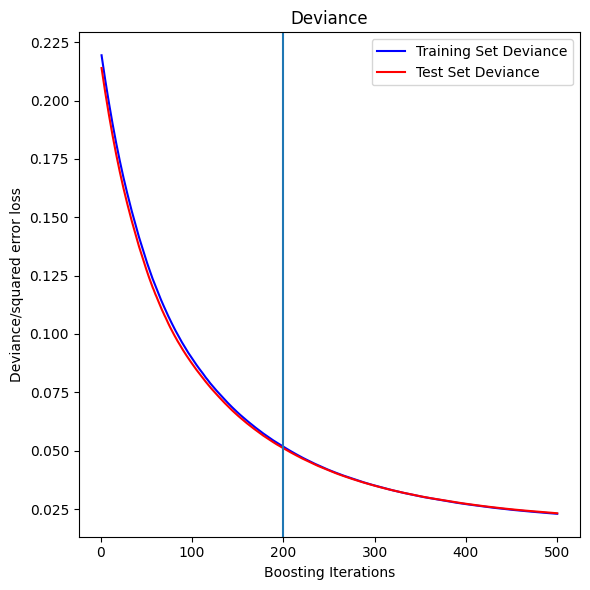

In [50]:
for i, y_pred in enumerate(reg.staged_predict(X_vali)):
    test_score[i] = reg.loss_(Y_vali, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)

#plt.axvline((np.arange(params["n_estimators"]) + 1)[np.argmin(test_score)])
plt.axvline(200)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance/squared error loss")
fig.tight_layout()
plt.show()

<font color="blue"> On utilise la méthode d'early stopping, on prend là où le courbe est minimale pour le test et ou ca commence à diverger entre les 2 courbes pour éviter l’overfitting. On fixe donc le nombre de prédicteurs/nimbre d'itérations à 200, juste avant la divergence entre les deux courbes.

In [51]:
# définition des paramètres
# apprentissage
param=[{"learning_rate":[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1], "max_depth": np.arange(2,20,3)}]#optimisation de m
rf= GridSearchCV(GradientBoostingRegressor(n_estimators=200),param,cv=5,n_jobs=-1)
boostOpt=rf.fit(X_train, Y_train)

# paramètre optimal
print("Error la moins élevée = %f, Meilleur paramètre = %s" % (1. -boostOpt.best_score_,boostOpt.best_params_)) #1-R^2

Error la moins élevée = 0.037350, Meilleur paramètre = {'learning_rate': 0.09, 'max_depth': 17}


## Prédiction de l'échantilon de validation

In [52]:
# prédiction du set de validation
prev=boostOpt.predict(X_vali)

In [53]:
# enlever la transformation initiale effectuée
prev_detransfo = np.exp(prev)
Y_vali_detransfo = np.exp(Y_vali)

In [58]:
print("Erreurs et performance du modèle Boosting pour prédire le prix des hotels ")
print("-------------------------------------------------------------------")

print("erreur généralisation en Python= ", 1-boostOpt.score(X_vali, Y_vali_detransfo))

print("RMSE= ",np.sqrt(mean_squared_error(Y_vali_detransfo,prev_detransfo)))
print("MAE= ",mean_absolute_error(Y_vali_detransfo,prev_detransfo))

Erreurs et performance du modèle Boosting pour prédire le prix des hotels 
-------------------------------------------------------------------
erreur généralisation en Python=  4.8948758682757365
RMSE=  10.69513434985976
MAE=  6.331855707602782


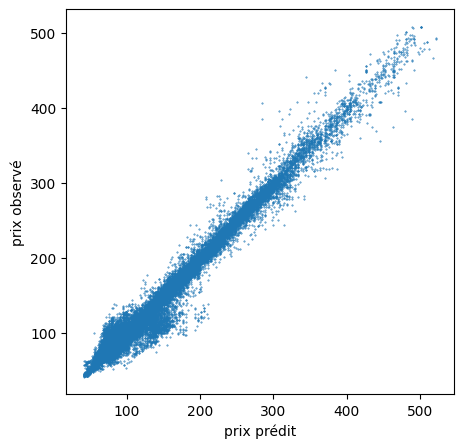

In [55]:
plot_pred_obs(Y_vali_detransfo,prev_detransfo)

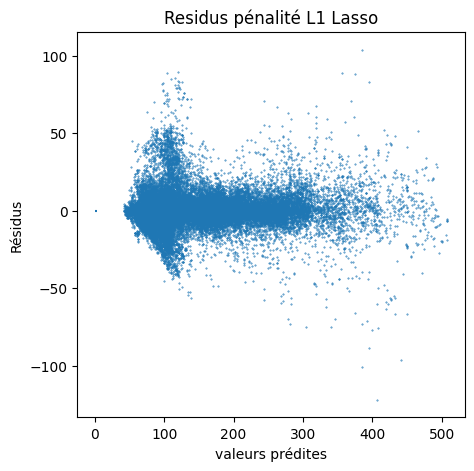

In [56]:
scatterplot_residuals(Y_vali_detransfo,prev_detransfo)

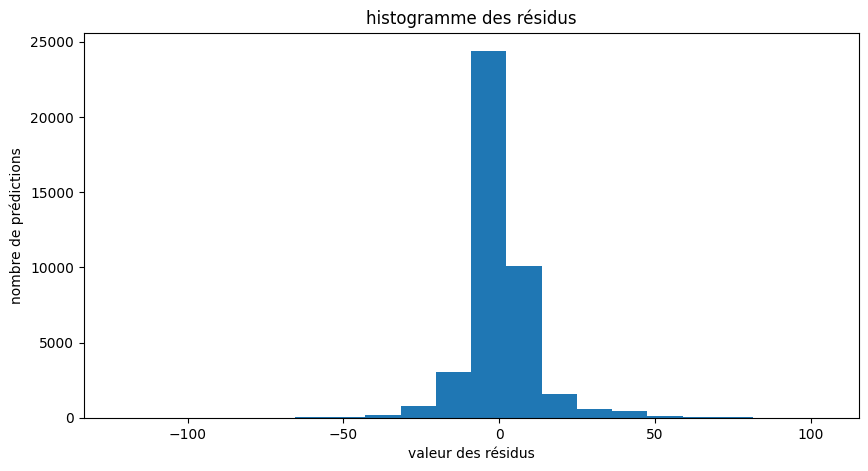

In [57]:
histogram_residuals(Y_vali_detransfo,prev_detransfo)

## On réentraine le modèle sur toutes les données et on calcule la prédiction sur l'échantillon de test

In [63]:
# apprentissage
param=[{"learning_rate":[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1], "max_depth": np.arange(2,20,3)}]#optimisation de m
rf_complet= GridSearchCV(GradientBoostingRegressor(n_estimators=200), param,cv=5,n_jobs=-1)
boostOpt_complet=rf_complet.fit(X.drop(['avatar_id','hotel_id'],axis=1), Y)

# paramètre optimal
print("Error la moins élevée = %f, Meilleur paramètre = %s" % (1. -boostOpt.best_score_,boostOpt.best_params_)) #1-R^2

/home/julie/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Error la moins élevée = 0.037350, Meilleur paramètre = {'learning_rate': 0.09, 'max_depth': 17}


In [64]:
# prédiction du set de test
prev_test=boostOpt_complet.predict(X_test)
prev_test = pd.DataFrame(np.exp(prev_test),columns=['price'])
download_pred_Xtest(prev_test,'prediction_boosting')